In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.ndimage
from matplotlib import animation, rc
from tqdm.notebook import tqdm
from IPython.display import HTML

from numba import njit

COLOR_BLACK = 0.5
COLOR_WHITE = 1.0
COLOR_NONE = 0.0


@njit(fastmath=True)
def create(x_len,y_len):
    '''Creates ndarray with shape (x_len, y_len) with values in {0, 0.5 , 1}'''

    return (np.random.randint(0,3,(x_len,y_len))/2)


def plotmap(map):
    '''Plot image of map '''
    
    plt.style.use('default')
    cmap = plt.cm.get_cmap("viridis", 3)
    plt.imshow(map.T, origin='lower', cmap=cmap)
    plt.colorbar(ticks = np.linspace(0,1,3))

    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid( which= 'minor',color = 'w', linestyle ='-', linewidth=2)
    plt.show()

@njit(fastmath=True)
def flip(map,x1,y1,x2,y2):
    '''Swaps 2 points in map 
    first: (x1,y1) and second: (x2,y2)'''

    map[x1][y1], map[x2][y2] = map[x2][y2], map[x1][y1]
    return map  


@njit(fastmath=True)
def get_neighbors(map, x, y):
    '''find neighbors of point (x,y) in map
    returns indexes of the neighbors'''
    
    x_minus = x-1 >= 0
    x_plus = x+1 < map.shape[0]
    y_plus = y+1 < map.shape[1]
    y_minus = y-1 >= 0

    indexes = []
    
    if x_minus:
        indexes.append(map[x-1][y])

    if x_plus:
        indexes.append(map[x+1][y])
    
    if x_minus and y_minus:
        indexes.append(map[x-1][y-1])

    if y_plus and x_plus:
        indexes.append(map[x+1][y+1])

    if x_minus and y_plus:
        indexes.append(map[x-1][y+1])

    if y_minus:
        indexes.append(map[x][y-1])
    
    if y_plus:
        indexes.append(map[x][y+1])

    if x_plus and y_minus:
        indexes.append(map[x+1][y-1])

    return indexes

@njit(fastmath=True)
def is_not_happy(map , x, y, level):
    '''define if the cell with coordinate (x,y) in map is NOT "happy" 
    "happy" if @level number of neighbors has the same type that (x,y)
    Returns: 
    True - Unhappy, we need to move it
    False - Happy, don't move it '''

    neigbors = get_neighbors(map,x,y)

    n = 0 
    
    for neigbor in neigbors:
        if neigbor == map[x][y]:
            n+=1
    
    if n >= level:
        return False

    return True

@njit(fastmath=True)
def find_random_hole(map):
    '''Finds random cell in map that has value 0.0
    Returns x and y coord of this point'''

    holes = np.argwhere(map==0)

    rand_index = np.random.randint(holes.shape[0])
    rand_x = holes[rand_index][0]
    rand_y = holes[rand_index][1]

    return rand_x, rand_y

@njit(fastmath=True)
def play_round_(map, level=4):
    '''Simulate round with map and specific parameter R
    Returns: new @map with moved cells'''

    #Run along all cells
    for index, cell in np.ndenumerate(map):
        # If it's not a hole
        if cell != COLOR_NONE:
            # If it's unhappy cell
            if is_not_happy(map, index[0], index[1], level):
                # find new free space for it
                x_hole, y_hole = find_random_hole(map)
                # aand move it there
                map = flip(map, index[0], index[1], x_hole, y_hole)

    return map


@njit(fastmath=True)
def play_round(map, level=4):
    '''Simulate round with map and specific parameter R
    Returns: new number of unhappy cells'''
    
    unhappy_cells = 0 

    for index, cell in np.ndenumerate(map):
        if cell != COLOR_NONE:
            if is_not_happy(map, index[0], index[1], level):
                x_hole, y_hole = find_random_hole(map)
                map = flip(map, index[0], index[1], x_hole, y_hole)
                unhappy_cells+=1

    return unhappy_cells


def play_(map, level=4):
    '''Simulate round with map and specific parameter R
    Returns: new @map with moved cells'''


    l = []
    for cord,_ in np.ndenumerate(map):
        l.append(cord)
    coords = np.random.permutation(l)

    #Run along all cells
    for coord in coords:
        
        x = int(coord[0])
        y = int(coord[1])
        #print(type(x),x)
        #print(type(y),y)
    
        # If it's not a hole
        if map[x][y] != COLOR_NONE:
            # If it's unhappy cell
            if is_not_happy(map, x, y, level):
                # find new free space for it
                x_hole, y_hole = find_random_hole(map)
                # aand move it there
                map = flip(map, x, y, x_hole, y_hole)

    return map

def play(map, level=4):
    '''Simulate round with map and specific parameter R
    Returns: new @map with moved cells'''
    unhappy_cells = 0 

    l = []
    for cord,_ in np.ndenumerate(map):
        l.append(cord)
    coords = np.random.permutation(l)

    #Run along all cells
    for coord in coords:
        
        x = int(coord[0])
        y = int(coord[1])
        #print(type(x),x)
        #print(type(y),y)
    
        # If it's not a hole
        if map[x][y] != COLOR_NONE:
            # If it's unhappy cell
            if is_not_happy(map, x, y, level):
                # find new free space for it
                x_hole, y_hole = find_random_hole(map)
                # aand move it there
                map = flip(map, x, y, x_hole, y_hole)
                unhappy_cells+=1

    return unhappy_cells

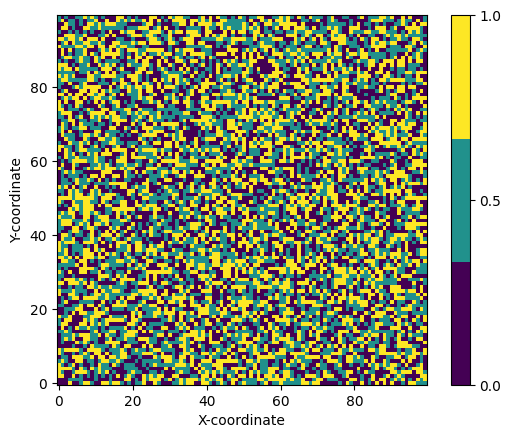

In [ ]:
map = create(100,100)
plotmap(map)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def anim(level, frames):
    '''Do @frames number of iterations with specific @level param
    Returns: animation of iterations'''

    def updatefig(i, map):
        if i == 0:
            im.set_array(map)
        else:    
                im.set_array(play_(map,level));
        return im,

    map = create(100,100)

    plt.style.use('default')
    cmap = plt.cm.get_cmap("viridis", 3)
    fig,ax = plt.subplots(figsize=(6,6))
    plt.xlabel("X-coordinate", fontsize = 16)
    plt.ylabel("Y-coordinate", fontsize = 16)
    plt.title("R = "+ str(level), fontsize = 18)
    im = plt.imshow(map.T, cmap=cmap ,origin='lower', animated = True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(cax= cax,ticks = np.linspace(0,1,3))

    anim = animation.FuncAnimation(fig, updatefig, frames = tqdm(np.arange(frames)), fargs = (map,) ,  interval = 200,  repeat = False)
    rc('animation', html='jshtml');
    return anim 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def anima(level, frames):
    '''Do @frames number of iterations with specific @level param
    Returns: animation of iterations'''

    def updatefig(i, map):
        if i == 0:
            im.set_array(map)
        else:    
                im.set_array(play_(play_(play_(play_(play_(play_(play_(map,5),5),5),5),5),5),5));
        return im,

    map = create(100,100)

    plt.style.use('default')
    cmap = plt.cm.get_cmap("viridis", 3)
    fig,ax = plt.subplots(figsize=(6,6))
    plt.xlabel("X-coordinate", fontsize = 16)
    plt.ylabel("Y-coordinate", fontsize = 16)
    plt.title("R = "+ str(level), fontsize = 18)
    im = plt.imshow(map.T, cmap=cmap ,origin='lower', animated = True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(cax= cax,ticks = np.linspace(0,1,3))

    anim = animation.FuncAnimation(fig, updatefig, frames = tqdm(np.arange(frames)), fargs = (map,) ,  interval = 200,  repeat = False)
    rc('animation', html='jshtml');
    return anim 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def an(level, frames):
    '''Do @frames number of iterations with specific @level param
    Returns: animation of iterations'''

    def updatefig(i, map):
        if i == 0:
            im.set_array(map)
        else:    
                im.set_array(play_(map,5))
        return im,

    map = create(17,17)

    plt.style.use('default')
    cmap = plt.cm.get_cmap("viridis", 3)
    fig,ax = plt.subplots(figsize=(6,6))
    plt.xlabel("X-coordinate", fontsize = 16)
    plt.ylabel("Y-coordinate", fontsize = 16)
    plt.title("R = "+ str(level), fontsize = 18)
    im = plt.imshow(map.T, cmap=cmap ,origin='lower', animated = True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(cax= cax,ticks = np.linspace(0,1,3))

    anim = animation.FuncAnimation(fig, updatefig, frames = tqdm(np.arange(frames)), fargs = (map,) ,  interval = 200,  repeat = False)
    rc('animation', html='jshtml');
    return anim 

In [ ]:
an(5,500)

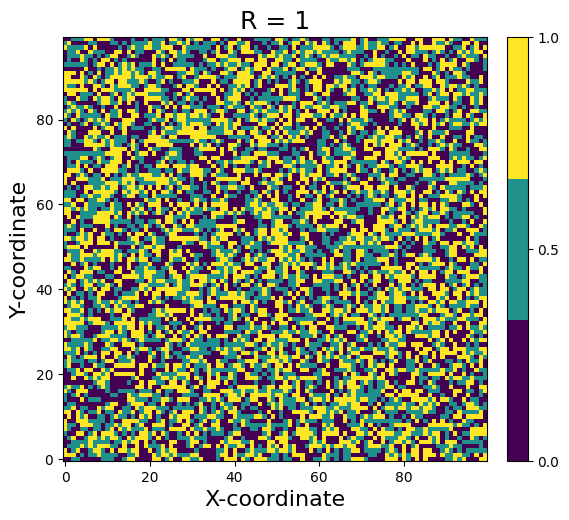

In [ ]:
anim(1,5)

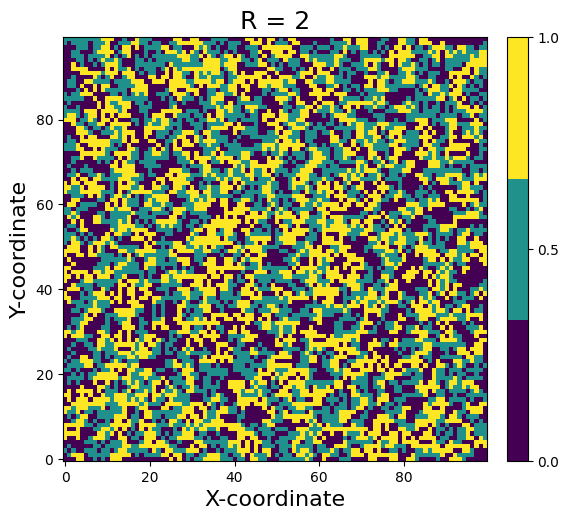

In [ ]:
anim(2,12)

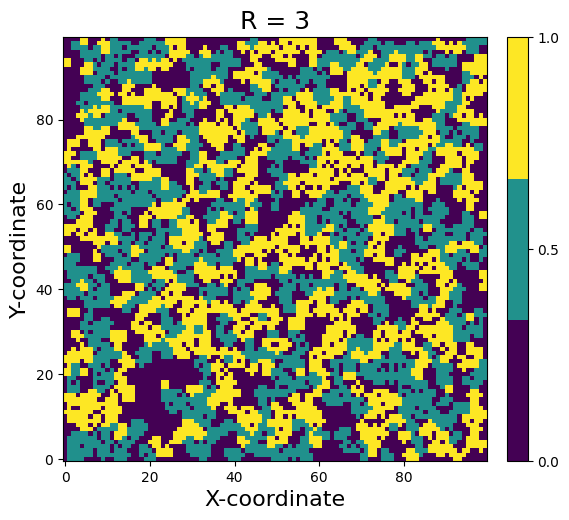

In [ ]:
anim(3,25)

In [ ]:
anim(4,140)

In [ ]:
anim(5,2000)

In [ ]:
anima(5,600)

In [ ]:
anim(6,140)

In [ ]:
anim(7,140)

In [ ]:
anim(8,140)

In [ ]:
''' You can download gifs here'''
# from google.colab import files
# anim.save('img.gif', writer='pillow', fps=20)
# files.download('img.gif')

In [ ]:
from numba import njit, prange

#@njit(fastmath=True, parallel=True)
def calculate(level):
    ''' Do 60 iterations 3 times'''

    n_repetitions = 3
    n_iterations = 100

    results = np.empty((n_repetitions,n_iterations))

    for i in prange(n_repetitions):
        map = create(100,100)
        for j in range(n_iterations): #200
            results[i][j] = play(map,level)
    
    return results

In [ ]:
def getlines():
    ''' Do 60 iterations for each param R
    and find mean'''
    n_plots = 8
    n_iterations = 100

    r = range(1,n_plots+1)

    ar = np.empty((n_plots, n_iterations))
    for lev in r:
        res = calculate(lev)
        res = np.mean(res, axis = 0)
        ar[lev-1,:] = res

    return ar


In [ ]:
lines = getlines()

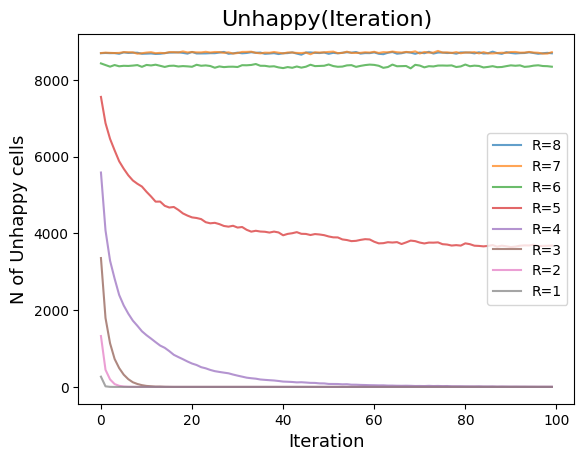

In [ ]:
n_iterations = 100
plt.plot(np.arange(n_iterations),lines[7], alpha = 0.7, label = 'R=8')
plt.plot(np.arange(n_iterations),lines[6], alpha = 0.7, label = 'R=7')
plt.plot(np.arange(n_iterations),lines[5], alpha = 0.7, label = 'R=6')
plt.plot(np.arange(n_iterations),lines[4], alpha = 0.7, label = 'R=5')
plt.plot(np.arange(n_iterations),lines[3], alpha = 0.7, label = 'R=4')
plt.plot(np.arange(n_iterations),lines[2], alpha = 0.7, label = 'R=3')
plt.plot(np.arange(n_iterations),lines[1], alpha = 0.7, label = 'R=2')
plt.plot(np.arange(n_iterations),lines[0], alpha = 0.7, label = 'R=1')
plt.xlabel("Iteration",fontsize = 13)
plt.ylabel("N of Unhappy cells",fontsize = 13)
plt.title("Unhappy(Iteration)",fontsize = 16)
plt.legend()

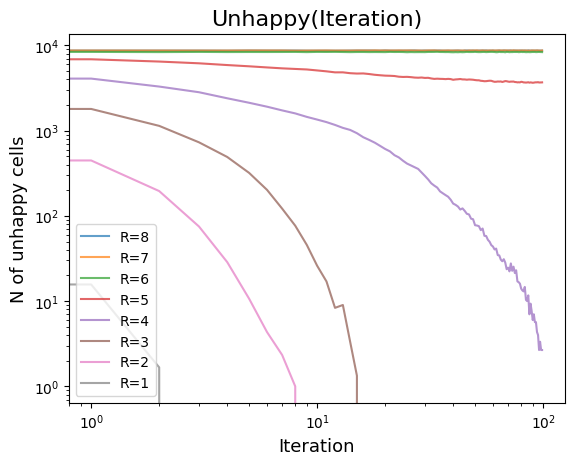

In [ ]:
n_iterations = 100
plt.yscale(value='log')
plt.xscale(value='log')
plt.plot(np.arange(n_iterations),lines[7], alpha = 0.7, label = 'R=8')
plt.plot(np.arange(n_iterations),lines[6], alpha = 0.7, label = 'R=7')
plt.plot(np.arange(n_iterations),lines[5], alpha = 0.7, label = 'R=6')
plt.plot(np.arange(n_iterations),lines[4], alpha = 0.7, label = 'R=5')
plt.plot(np.arange(n_iterations),lines[3], alpha = 0.7, label = 'R=4')
plt.plot(np.arange(n_iterations),lines[2], alpha = 0.7, label = 'R=3')
plt.plot(np.arange(n_iterations),lines[1], alpha = 0.7, label = 'R=2')
plt.plot(np.arange(n_iterations),lines[0], alpha = 0.7, label = 'R=1')
plt.xlabel("Iteration",fontsize = 13)
plt.ylabel("N of unhappy cells",fontsize = 13)
plt.title("Unhappy(Iteration)",fontsize = 16)
plt.legend()

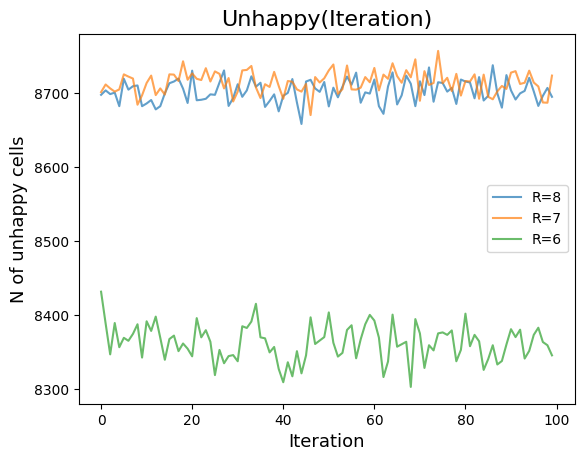

In [ ]:
plt.plot(np.arange(n_iterations),lines[7], alpha = 0.7, label = 'R=8')
plt.plot(np.arange(n_iterations),lines[6], alpha = 0.7, label = 'R=7')
plt.plot(np.arange(n_iterations),lines[5], alpha = 0.7, label = 'R=6')

plt.xlabel("Iteration",fontsize = 13)
plt.ylabel("N of unhappy cells",fontsize = 13)
plt.title("Unhappy(Iteration)",fontsize = 16)
plt.legend()

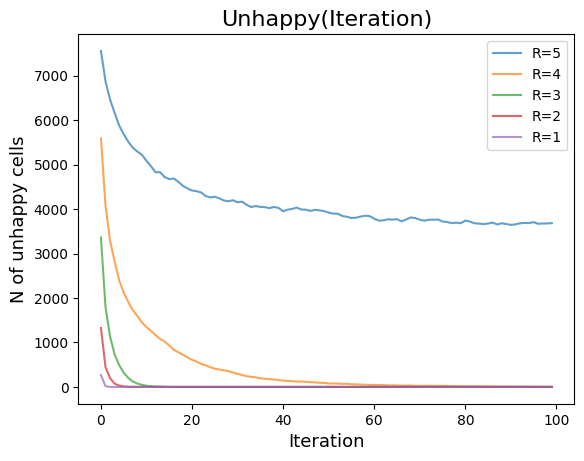

In [ ]:
plt.plot(np.arange(n_iterations),lines[4], alpha = 0.7, label = 'R=5')
plt.plot(np.arange(n_iterations),lines[3], alpha = 0.7, label = 'R=4')
plt.plot(np.arange(n_iterations),lines[2], alpha = 0.7, label = 'R=3')
plt.plot(np.arange(n_iterations),lines[1], alpha = 0.7, label = 'R=2')
plt.plot(np.arange(n_iterations),lines[0], alpha = 0.7, label = 'R=1')
plt.xlabel("Iteration",fontsize = 13)
plt.ylabel("N of unhappy cells",fontsize = 13)
plt.title("Unhappy(Iteration)",fontsize = 16)
plt.legend()